In [1]:
import os

# Check if we're in the root directory of rl-llm repo
if not os.path.basename(os.getcwd()) == 'rl-llm':
    # If we're in a subdirectory of rl-llm, find the root and cd to it
    current_path = os.getcwd()
    while os.path.basename(current_path) != 'rl-llm' and os.path.dirname(current_path) != current_path:
        current_path = os.path.dirname(current_path)
    
    if os.path.basename(current_path) == 'rl-llm':
        os.chdir(current_path)
        print(f"Changed directory to: {current_path}")
    else:
        print("Not in rl-llm repository structure")
else:
    print("Already in rl-llm root directory")

print(f"Current directory: {os.getcwd()}")

Changed directory to: /workspace/rl-llm
Current directory: /workspace/rl-llm


In [2]:
from src import EnvManager, sample_batch
import time
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/venv/main/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-GoTo-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/venv/main/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Open-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/venv/main/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Pickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/venv/main/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-PutNext-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "meta-llama/Llama-3.2-3B-Instruct" # "meta-llama/Llama-3.2-3B-Instruct" # TODO: Test Llama-1B and Llama-3B (and optionally Qwen with reasoning)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
generation_kwargs = {
    "max_new_tokens": 20,
    "do_sample": True,
    "top_k": 10,
    "top_p": 0.95,
    "temperature": 0.8,
}
env_id = "BabyAI-PutNext-v0" # TODO: Test GoTo, Pickup, PutNext, Open, and PickUpSeqGoTo
env_ids = [env_id]
context_window = 5# TODO: Test 1, 2, 3, and 5 (if it's feasible)
num_envs = 4 # TODO: See what is optimal for you (might vary with model, env, and device)
envs = [
        EnvManager(
            env_ids, 
            invalid_action_penalty=-2,
            consecutive_invalid_actions_allowed=5,
        )
        for i in range(num_envs)
    ]
reasoning_flag = False
batch_size = 128
# TODO: You may also need to play around with the system_prompt to get valid actions if testing other models such as 1B or Qwen

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
total_times = []
total_generate_times = []
num_episodes_per_batch = []
successs = []
rewardss = []
episode_lengths = []
num_invalid_actions = []

num_batches = 3
for i in range(num_batches):

    start_time = time.time()
    queries, responses, rewards, stats, running_stats = sample_batch(
        envs,
        tokenizer,
        model,
        generation_kwargs,
        device,
        batch_size=batch_size,
        context_window=context_window,
        reasoning_flag = reasoning_flag,
    )
    end_time = time.time()
    sample_batch_time = end_time - start_time

    total_times.append(sample_batch_time)
    total_generate_times.append(stats["total_generate_time"])
    num_episodes = len(running_stats['success'][env_id])
    num_episodes_per_batch.append(num_episodes)

    successs.extend(running_stats['success'][env_id])
    rewardss.extend(running_stats['rewards'][env_id])
    episode_lengths.extend(running_stats['episode_lengths'][env_id])
    num_invalid_actions.extend(running_stats['num_invalid_actions'][env_id])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

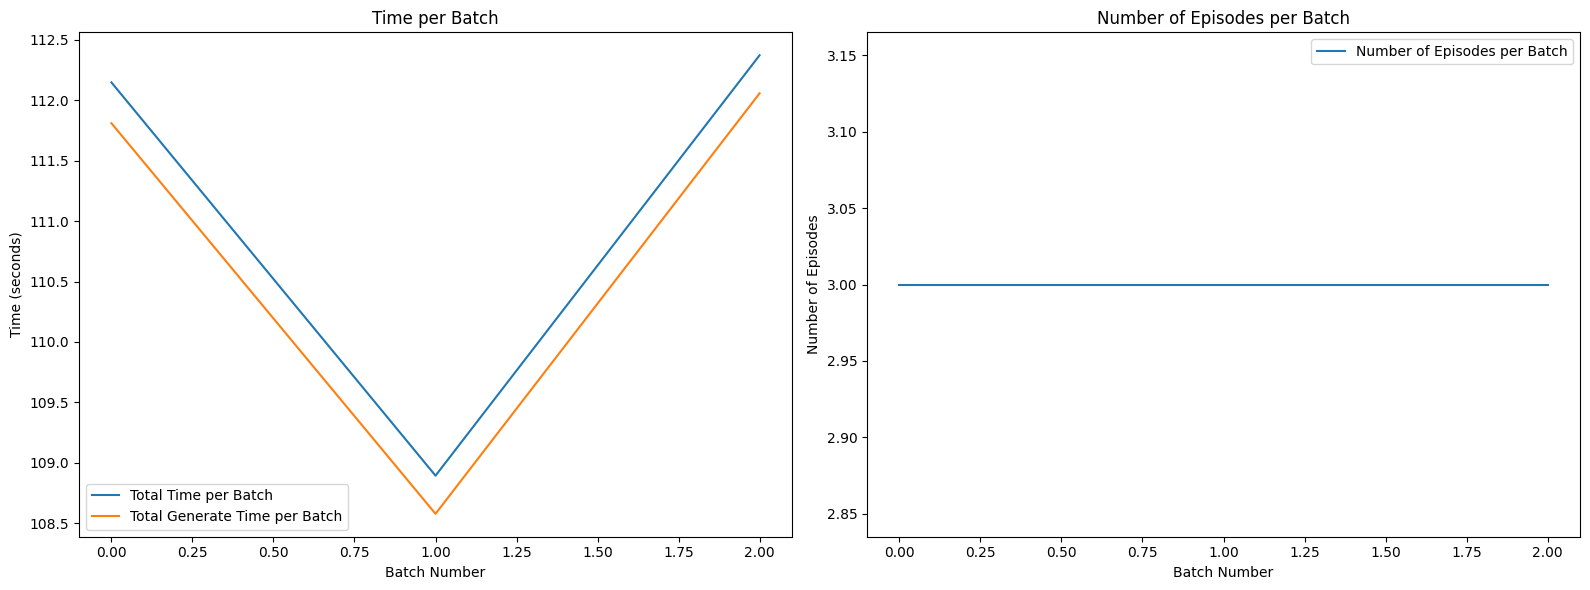

In [5]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot times
axes[0].plot(total_times, label='Total Time per Batch')
axes[0].plot(total_generate_times, label='Total Generate Time per Batch')
axes[0].set_xlabel('Batch Number')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Time per Batch')
axes[0].legend()

# Plot number of episodes
axes[1].plot(num_episodes_per_batch, label='Number of Episodes per Batch')
axes[1].set_xlabel('Batch Number')
axes[1].set_ylabel('Number of Episodes')
axes[1].set_title('Number of Episodes per Batch')
axes[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

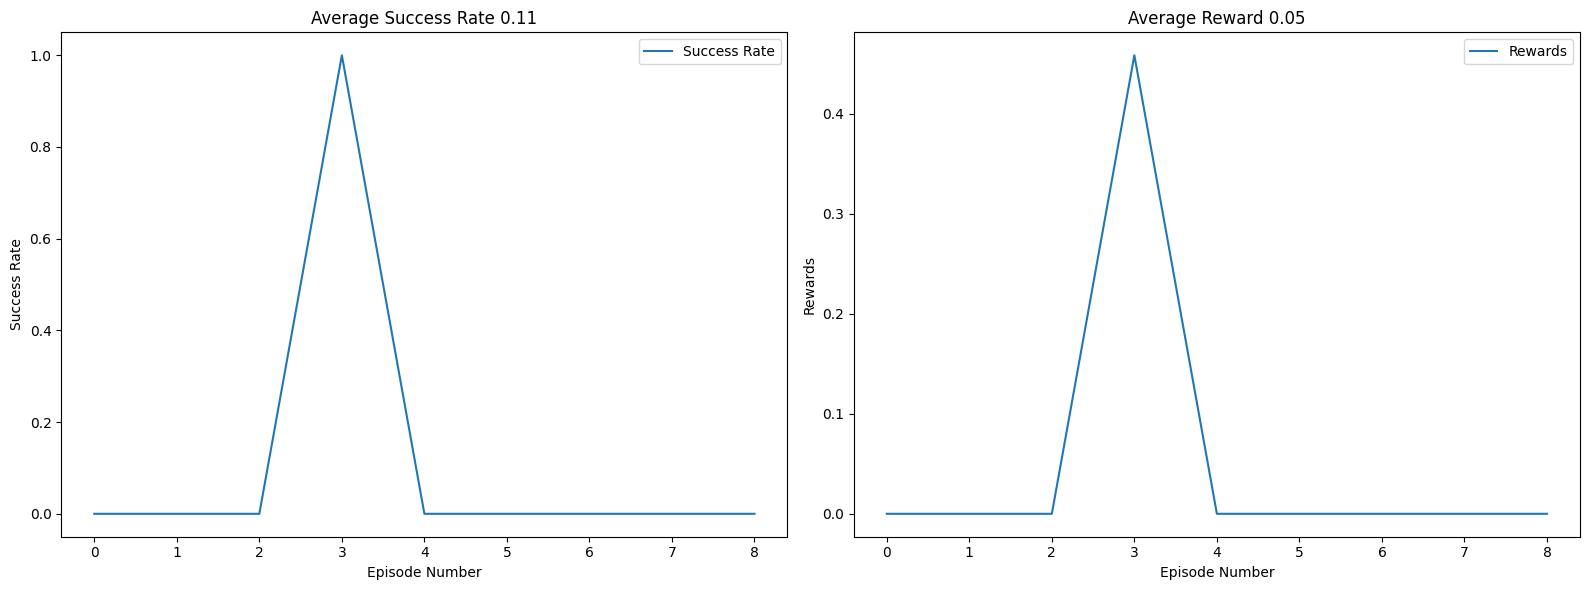

In [6]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the success curve
axes[0].plot(successs, label='Success Rate')
axes[0].set_xlabel('Episode Number')
axes[0].set_ylabel('Success Rate')
axes[0].set_title(f'Average Success Rate {sum(successs)/len(successs):.2f}')
axes[0].legend()

# Plot the rewards curve
axes[1].plot(rewardss, label='Rewards')
axes[1].set_xlabel('Episode Number')
axes[1].set_ylabel('Rewards')
axes[1].set_title(f'Average Reward {sum(rewardss)/len(rewardss):.2f}')
axes[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

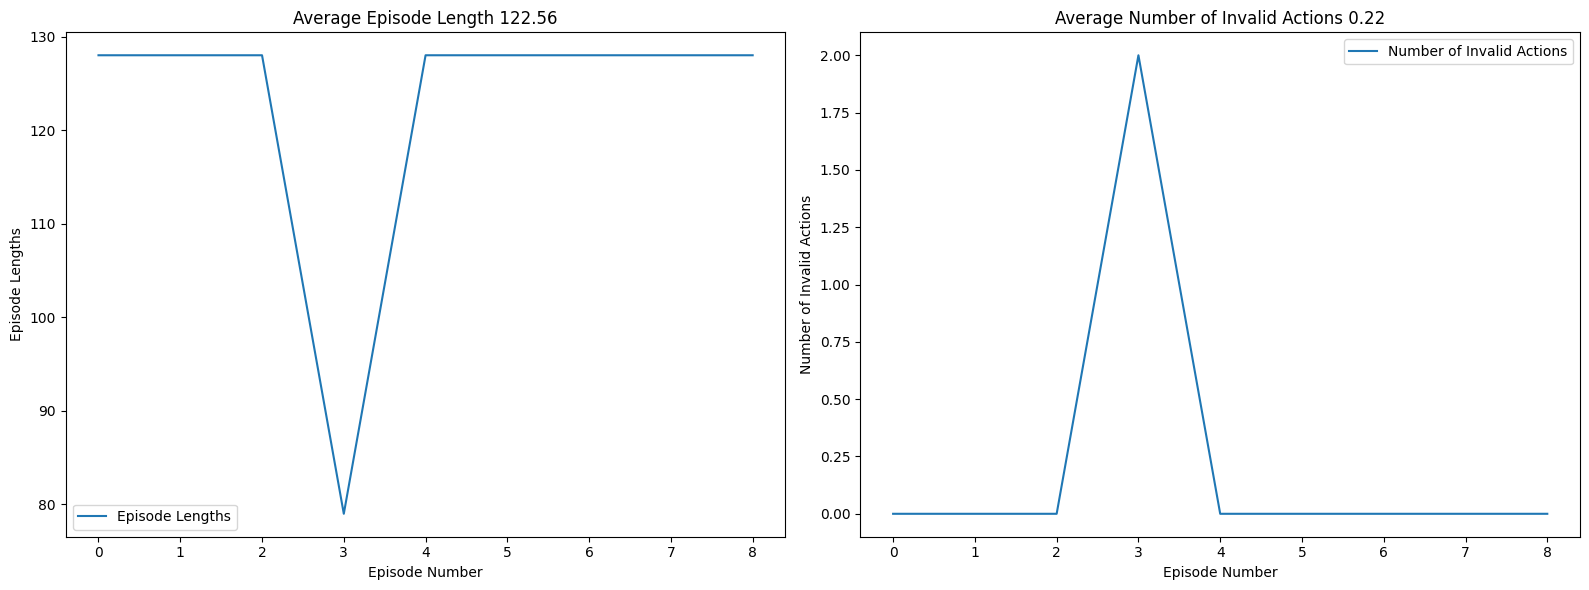

In [7]:
# Plot the episode lengths and number of invalid actions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot the episode lengths curve
axes[0].plot(episode_lengths, label='Episode Lengths')
axes[0].set_xlabel('Episode Number')
axes[0].set_ylabel('Episode Lengths')
axes[0].set_title(f'Average Episode Length {sum(episode_lengths)/len(episode_lengths):.2f}')
axes[0].legend()
# Plot the number of invalid actions curve
axes[1].plot(num_invalid_actions, label='Number of Invalid Actions')
axes[1].set_xlabel('Episode Number')
axes[1].set_ylabel('Number of Invalid Actions')
axes[1].set_title(f'Average Number of Invalid Actions {sum(num_invalid_actions)/len(num_invalid_actions):.2f}')
axes[1].legend()
# Adjust layout and show
plt.tight_layout()
plt.show()